# Titanic

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
get_ipython().magic(u'matplotlib inline')

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data Exploration and Cleaning

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Missing values in column Age, Cabin and Embarked

### drop column PassengerId, Ticket, Cabin , for they seems not very useful

In [4]:
df.drop(['PassengerId','Ticket','Cabin'], inplace=True, axis=1)

In [5]:
df.describe()

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x106151c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x106415150>]], dtype=object)

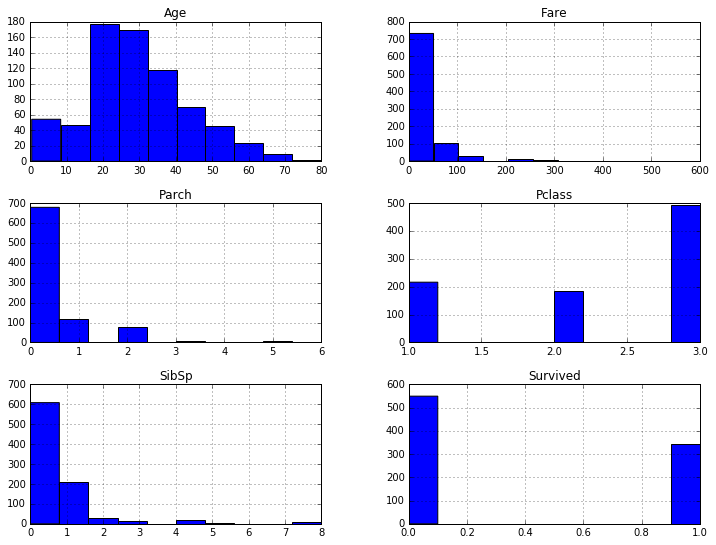

In [6]:
df.hist(figsize=(12,9
                ))

OrderedDict([('Survived',
              {'boxes': [<matplotlib.lines.Line2D at 0x106e2ab10>],
               'caps': [<matplotlib.lines.Line2D at 0x106e3ca10>,
               'fliers': [<matplotlib.lines.Line2D at 0x106e43d10>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x106e436d0>],
               'whiskers': [<matplotlib.lines.Line2D at 0x106e2acd0>,
                <matplotlib.lines.Line2D at 0x106e3c3d0>]}),
             ('Pclass',
              {'boxes': [<matplotlib.lines.Line2D at 0x106e53850>],
               'caps': [<matplotlib.lines.Line2D at 0x106e60710>,
               'fliers': [<matplotlib.lines.Line2D at 0x106e6ba10>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x106e6b3d0>],
               'whiskers': [<matplotlib.lines.Line2D at 0x106e539d0>,
                <matplotlib.lines.Line2D at 0x106e600d0>]}),
             ('Age',
              {'boxes': [<matplotlib.lines.Line2D at 0x106e77550>

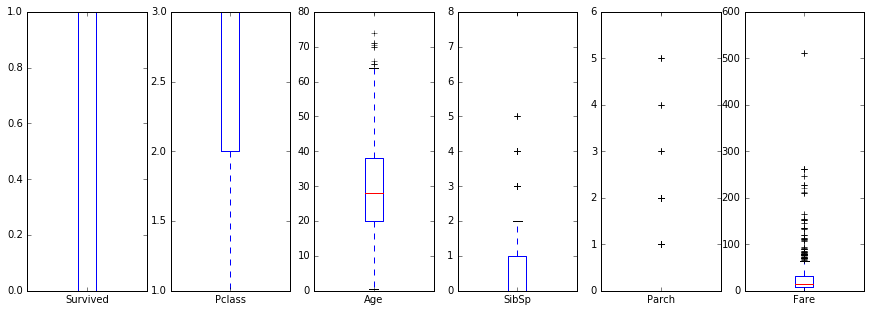

In [7]:
df.plot(kind='box', return_type='dict' , subplots = True, figsize=(15,5))

### Outliers exist in Age, SibSp, Fare, how do we want to treat them?

### fill the missing values in Age with median values. do we have a better way?

In [8]:
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace = True)

### treat the missing values in Embarked

In [9]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [10]:
# check Embarked values
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

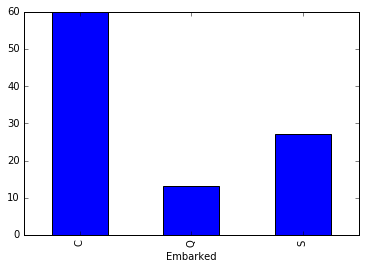

In [11]:
df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [12]:
# it seems that based on Fare-Embarked relationship, the missing values are likely C.
df.Embarked.fillna('C', inplace=True)

In [13]:
df.Embarked = df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [14]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

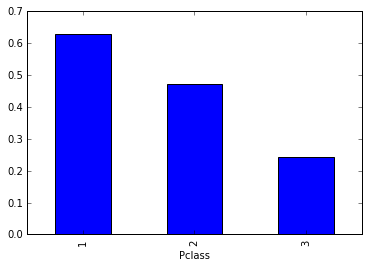

In [15]:
df.pivot_table(values='Survived',
               index=['Pclass'],
               aggfunc=np.mean).plot(kind='bar')

Pclass 1 and 2 have much better chance of surviving than Pclass 3.
However, this would have been factored in tree based models.

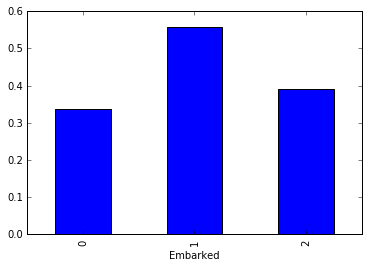

In [16]:
df.pivot_table(values='Survived',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

## Feature Construction

In [17]:
df['FamilySize'] = df['SibSp'] + df['Parch']

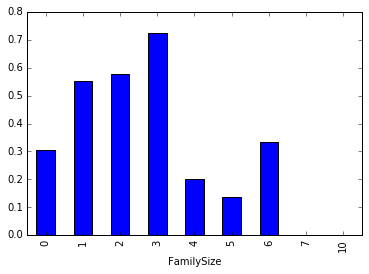

In [18]:
df.pivot_table(values='Survived',
               index=['FamilySize'],
               aggfunc=np.mean).plot(kind='bar')

In [19]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,0,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,0,0


In [20]:
adult_age = 16
df['Person'] = df[['Age','Sex']].apply(lambda x: 'child' if x[0]<adult_age else x[1], axis=1)
df.Person = df.Person.astype(str).map({'male':1,'female':0,'child':2})

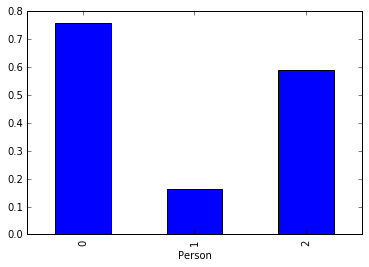

In [21]:
df.pivot_table(values='Survived',
               index=['Person'],
               aggfunc=np.mean).plot(kind='bar')

In [22]:
df.Person.value_counts()

1    537
0    271
2     83
Name: Person, dtype: int64

In [23]:
# according to the women and child first policy,
# if a wife who has children died, it is likely the whole family died
# and if a husband who has children survived, it is likely the whole family survived
# therefore, we use surname to check if the person is with perished_mother_wife or survive_father_husband
# to find out if he/she is survived.

# it would ideal that ML would discover this on its own, but at present it seems not.
# New features like this are useful to narrow its search

df['surname'] = df['Name'].apply(lambda name: name.split(',')[0].lower())

perishing_female_surnames = df[(df.Person==0) & (df.Survived ==0) & (df.FamilySize > 0)]['surname'].unique()
print('Total female adult victims with family:', len(perishing_female_surnames))

('Total female adult victims with family:', 30)


In [24]:
df['perish_mother_wife'] = df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)


In [25]:
survive_male_surnames = df[(df.Person==1) & (df.Survived ==1) & (df.FamilySize > 0)]['surname'].unique()

In [26]:
df['survive_father_husband'] = df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [27]:
# finish up and predict

df.drop(['SibSp','Parch','Name','surname','Sex','Age'],axis=1, inplace=True)

In [28]:
predictor_var = list(df.columns[1:])
print predictor_var
outcome_var = 'Survived'

['Pclass', 'Fare', 'Embarked', 'FamilySize', 'Person', 'perish_mother_wife', 'survive_father_husband']


In [29]:
categorical = ['Pclass','Person','Embarked','perish_mother_wife','survive_father_husband']
non_categorical = [ i for i in predictor_var if i not in categorical ]

In [30]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = ohe.fit_transform(df[categorical])

In [31]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_non_cat = sc.fit_transform(df[non_categorical])

In [32]:
from numpy import hstack
X = hstack((X_non_cat, X_cat))
y = df[outcome_var]
X.shape, X_non_cat.shape, X_cat.shape

((891, 15), (891, 2), (891, 13))

In [33]:
# dimension reduction then plot
#from sklearn import decomposition

#pca = decomposition.PCA(n_components=2)
#X_prime = pca.fit_transform(X)

In [34]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/modules/generated\
#/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          precision = 3):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], precision)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_cm(model, X, y, normalize = False, precision = 3):
    y_test = y
    y_pred = model.fit(X,y).predict(X)
    class_names = []

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=precision)


    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=normalize,
                          title='Confusion matrix', precision = precision)

    plt.show()    

Accuracy: 88.656% +/-2.47% lr_model


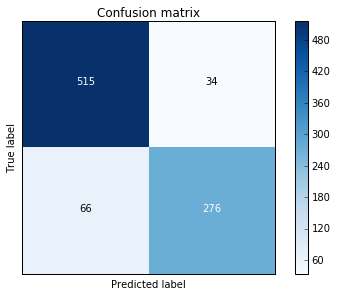

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} lr_model".format(scores.mean(), scores.std())
plot_cm(lr_model, X,y)

Accuracy: 88.544% +/-2.73% rf_model


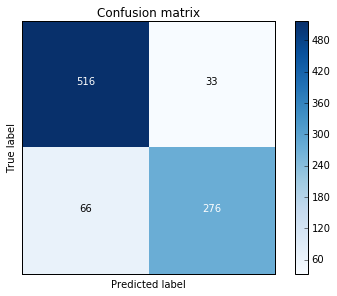

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators = 100, max_depth=4)
scores = cross_val_score(et, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} rf_model".format(scores.mean(), scores.std())
plot_cm(et, X,y)

{'warm_start': False, 'oob_score': False, 'n_jobs': 1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 300, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': 42, 'min_impurity_split': 1e-07, 'max_features': 1, 'max_depth': 6, 'class_weight': None}
Accuracy: 88.211% +/-2.83% rf_model


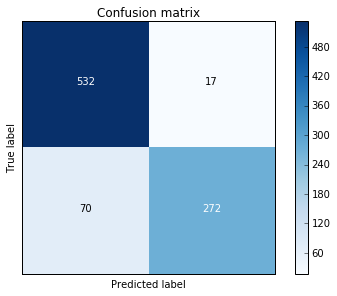

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=300, max_features = 1, max_depth=6,random_state=42)
print rf_model.get_params()
scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} rf_model".format(scores.mean(), scores.std())
plot_cm(rf_model, X,y)

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

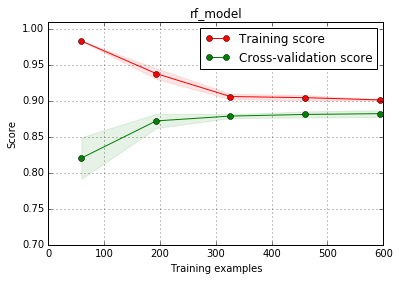

In [39]:
plot_learning_curve(rf_model, "rf_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [40]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} knn".format(scores.mean(), scores.std())

Accuracy: 86.774% +/-5.17% knn


Accuracy: 88.656% +/-2.76% svm_model


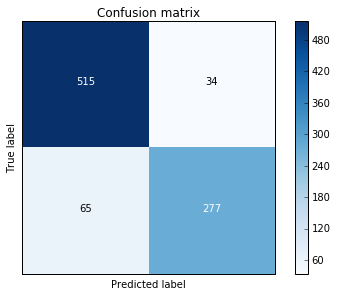

In [41]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=1)
scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} svm_model".format(scores.mean(), scores.std())
plot_cm(svm_model, X,y)

<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

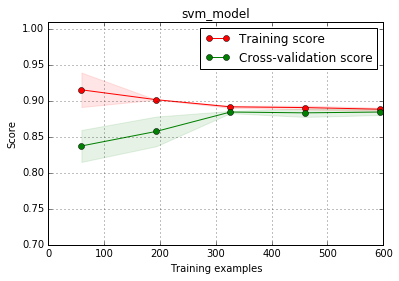

In [42]:
plot_learning_curve(svm_model, "svm_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [43]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(adaboost, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} adaboost".format(scores.mean(), scores.std())

Accuracy: 87.98% +/-2.63% adaboost


In [44]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} GaussianNB".format(scores.mean(), scores.std())

Accuracy: 85.524% +/-2.52% GaussianNB


In [45]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
scores = cross_val_score(xgb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} xgb".format(scores.mean(), scores.std())

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 88.659% +/-2.84% xgb


In [46]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    "max_depth": (1,2,3),
    "min_child_weight": (1,2,3)
}

gsearch1 = GridSearchCV(estimator = xgb, 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch1.fit(X, y)
#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 1}, 0.88888888888888884)

In [47]:
max_depth, min_child_weight = gsearch1.best_params_.values()

In [48]:
param_test = {
    "subsample": (.6,.75,.9),
    "colsample_bytree": (.6,.75,.9)
}

gsearch = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555), 
 param_grid = param_test, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.6}, 0.88888888888888884)

In [49]:
colsample_bytree = gsearch.best_params_['colsample_bytree']
subsample = gsearch.best_params_['subsample']

In [50]:
param_test = {
    "gamma": (1e-5,.1, 0,10, 1e5),
}

gsearch = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=0,
 subsample=subsample,
 colsample_bytree=colsample_bytree,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555), 
 param_grid = param_test, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_

({'gamma': 1e-05}, 0.88888888888888884)

In [51]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=1e-5,
 subsample=subsample,
 colsample_bytree=colsample_bytree,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
scores = cross_val_score(xgb2, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} xgb".format(scores.mean(), scores.std())

Accuracy: 88.882% +/-2.46% xgb


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

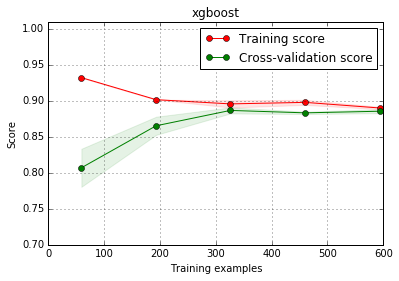

In [52]:
plot_learning_curve(xgb2, "xgboost", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [53]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('rf', rf_model), ('svm', svm_model),('xgb', xgb2)], voting='hard')

scores = cross_val_score(eclf, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())

Accuracy: 88.770% +/-2.68% eclf


/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

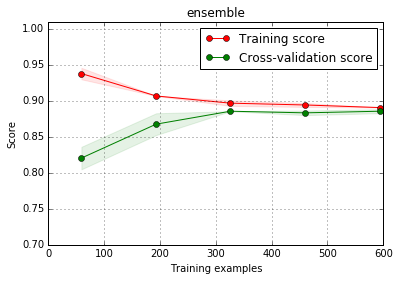

In [54]:
plot_learning_curve(eclf, "ensemble", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [55]:

"""
import tensorflow as tf
# Build 3 layer DNN with 1024, 512, 256 units respectively.
dnn = tf.contrib.learn.DNNClassifier(hidden_units=[1024,512,256],
n_classes=99)

scores = cross_val_score(dnn, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())

# Fit model.
dnn.fit(x=x_train, y=y_train, steps = 2000)

# Make prediction for test data
y = dnn.predict(x_test)
"""

'\nimport tensorflow as tf\n# Build 3 layer DNN with 1024, 512, 256 units respectively.\ndnn = tf.contrib.learn.DNNClassifier(hidden_units=[1024,512,256],\nn_classes=99)\n\nscores = cross_val_score(dnn, X, y, cv=10, scoring=\'accuracy\')\nprint "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())\n\n# Fit model.\ndnn.fit(x=x_train, y=y_train, steps = 2000)\n\n# Make prediction for test data\ny = dnn.predict(x_test)\n'

In [56]:
""" really slow
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(rf_model,
                            max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())
"""

' really slow\nfrom sklearn.ensemble import BaggingClassifier\n\nbagging = BaggingClassifier(rf_model,\n                            max_samples=0.5, max_features=0.5)\nscores = cross_val_score(bagging, X, y, cv=10, scoring=\'accuracy\')\nprint "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())\n'

In [57]:
# now work on test data
test_df.apply(lambda x: x.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [58]:
test_df.Age.fillna(test_df.Age.median(), inplace=True)

In [59]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [60]:
test_df.Embarked = test_df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [61]:
mean_fare = test_df[test_df.Embarked==0]['Fare'].mean() ; mean_fare

28.230436431226767

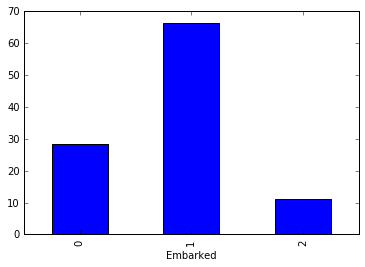

In [62]:
test_df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [63]:
test_df.Fare.fillna(mean_fare, inplace = True)

In [64]:
test_df['FamilySize'] = test_df.SibSp + test_df.Parch


In [65]:
test_df['Person'] = test_df[['Age','Sex']].apply(lambda x: 'child' if x[0]<adult_age else x[1], axis=1)
# first convert to str, then map
test_df.Person = test_df.Person.astype(str).map({'male':1,'female':0,'child':2})


In [66]:
# additional features

test_df['surname'] = test_df['Name'].apply(lambda name: name.split(',')[0].lower())

test_df['perish_mother_wife'] = test_df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)
test_df['survive_father_husband'] = test_df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [67]:
test_df.drop(['Name','surname','Sex','Age','SibSp','Parch','Ticket','Cabin'], inplace=True, axis=1)
test_df[:3]

,PassengerId,Pclass,Fare,Embarked,FamilySize,Person,perish_mother_wife,survive_father_husband
0,892,3,7.8292,2,0,1,0,0
1,893,3,7.0000,0,1,0,0,0
2,894,2,9.6875,2,0,1,0,0


In [68]:
# encoding, standarize
X_test_cat = ohe.transform(test_df[categorical])
X_test_non_cat = sc.transform(test_df[non_categorical])
X_test = hstack((X_test_non_cat, X_test_cat))

In [69]:
model = rf_model
model.fit(X,y)
Y_pred = model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submissions/rf10.csv', index=False)